### [Regression Data Analysis]
# KaKR House Price Prediction

---

# \# Data Columns Description

- `ID` : 집을 구분하는 번호


- `date` : 집을 구매한 날짜


- `price` : 집의 가격(Target variable)


- `bedrooms` : 침실의 수


- `bathrooms` : 침실 개수 당 화장실의 수(화장실의 수 / 침실의 수 )


- `sqft_living` : 주거 공간의 평방 피트(면적)


- `sqft_lot` : 부지의 평방 피트(면적)


- `floors` : 집의 층 수


- `waterfront` : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)


- `view` : 집이 얼마나 좋아 보이는지의 정도


- `condition` : 집의 전반적인 상태


- `grade` : King County grading 시스템 기준으로 매긴 집의 등급


- `sqft_above` : 지하실을 제외한 평방 피트(면적)


- `sqft_basement` : 지하실의 평방 피트(면적)


- `yr_built` : 지어진 년도


- `yr_renovated` : 집을 재건축한 년도


- `zipcode` : 우편번호


- `lat` : 위도


- `long` : 경도


- `sqft_living15` : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


- `sqft_lot15` : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

---
---

# \# Import Modules

먼저 앞으로의 데이터 분석에 필요한 module을 import한다.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

---
---

# \# Load Dataset

- 데이터 출처: [KaKR HousePrice Competition](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr)  


판다스 모듈을 이용해서 csv파일을 읽어서 앞으로 사용할 수 있도록 `train` 변수에 저장한다.  

In [2]:
data = pd.read_csv("./data/train.csv", index_col=['id'])
test = pd.read_csv("./data/test.csv", index_col=['id'])

In [3]:
print(data.shape)
data.tail()

(15035, 20)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
15034,20141015T000000,325000.0,2,0.75,1020,1076,2.0,0,0,3,7,1020,0,2008,0,98144,47.5941,-122.299,1020,1357


In [4]:
print(test.shape)
test.tail()

(6468, 19)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21502,20150116T000000,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


### DataType 확인

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 20 columns):
date             15035 non-null object
price            15035 non-null float64
bedrooms         15035 non-null int64
bathrooms        15035 non-null float64
sqft_living      15035 non-null int64
sqft_lot         15035 non-null int64
floors           15035 non-null float64
waterfront       15035 non-null int64
view             15035 non-null int64
condition        15035 non-null int64
grade            15035 non-null int64
sqft_above       15035 non-null int64
sqft_basement    15035 non-null int64
yr_built         15035 non-null int64
yr_renovated     15035 non-null int64
zipcode          15035 non-null int64
lat              15035 non-null float64
long             15035 non-null float64
sqft_living15    15035 non-null int64
sqft_lot15       15035 non-null int64
dtypes: float64(5), int64(14), object(1)
memory usage: 2.4+ MB


- `date` 컬럼을 제외하고는 모두 실수 또는 정수형 데이터이고, null data도 없으므로 특별한 전처리가 필요해 보이지는 않는다.

---
---

# \# Target Value : `price`

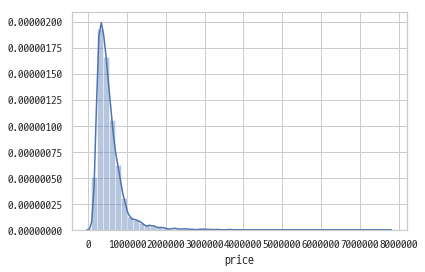

In [6]:
sns.distplot(data['price'])
plt.show()

- 치우친 형태의 왜곡된 데이터이므로 log 변환을 해준다.

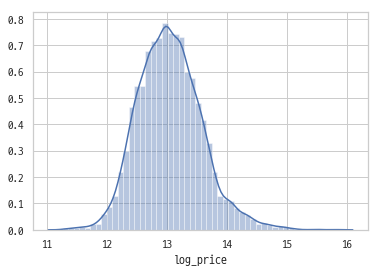

In [7]:
data['log_price'] = np.log1p(data['price'])
sns.distplot(data['log_price'])
plt.show()

# \# `Date` column

### Date Parsing

In [11]:
data[['date', 'price']].head()

,date,price
id,,
0,20141013T000000,221900.0
1,20150225T000000,180000.0
2,20150218T000000,510000.0
3,20140627T000000,257500.0
4,20150115T000000,291850.0


- `date` 컬럼은 문자형 데이터이고, 뒤에 불필요한 `T000000`이 붙어있으므로 제거한 후 `datetime` 으로 parsing 해준다.

In [12]:
data['date'] = data['date'].apply(lambda i: i[:8])
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,log_price
id,,,,,,,,,,,,,,,,,,,,,
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309987
1,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100718
2,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142168
3,2014-06-27,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,12.458779
4,2015-01-15,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,12.583999


- `date` 컬럼을 이용해 `month`, `year`, `year_month`, `day`, `day_of_week` (요일) 까지 생성해준다.

In [13]:
data['year'] = data.date.dt.year
data['month'] = data.date.dt.month
data['day']= data.date.dt.day
data['year_month'] = data.date.dt.year * 100 + data.date.dt.month
data['day_of_week'] = data.date.dt.dayofweek
data[['date', 'year', 'month', 'year_month', 'day', 'day_of_week']].head()

,date,year,month,year_month,day,day_of_week
id,,,,,,
0,2014-10-13,2014,10,201410,13,0
1,2015-02-25,2015,2,201502,25,2
2,2015-02-18,2015,2,201502,18,2
3,2014-06-27,2014,6,201406,27,4
4,2015-01-15,2015,1,201501,15,3


In [14]:
test['date'] = test['date'].apply(lambda i: i[:8])
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day']= test['date'].dt.day
test['year_month'] = test.date.dt.year * 100 + test.date.dt.month
test['day_of_week'] = test.date.dt.dayofweek

### Datetime ploting

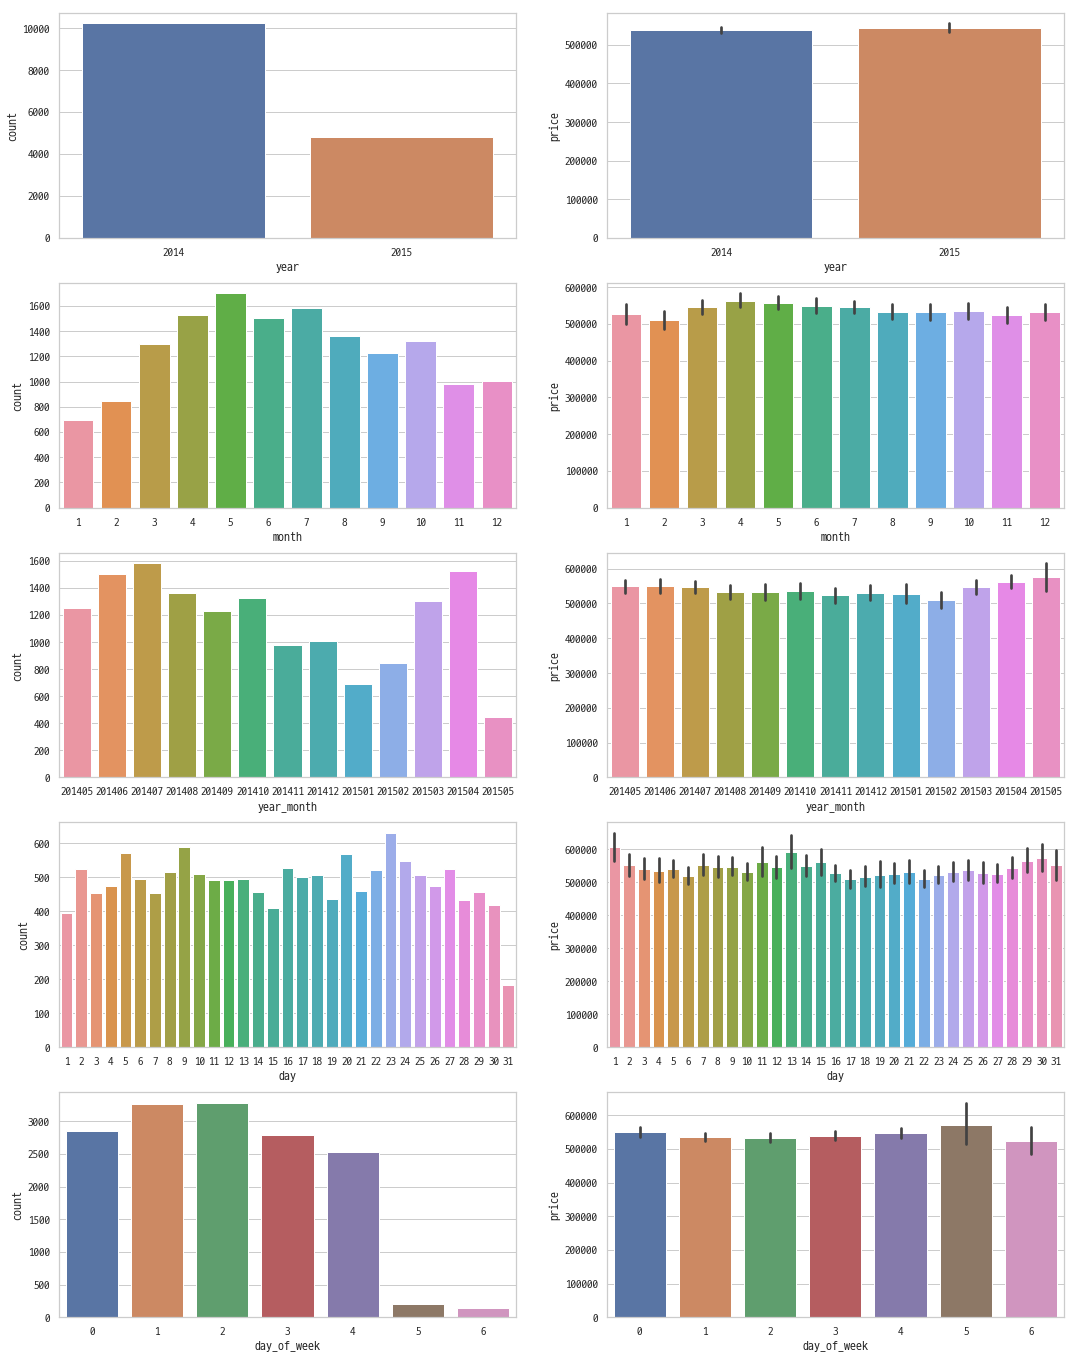

In [13]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(nrows=5, ncols=2)
figure.set_size_inches(18, 24)

sns.countplot(data=data, x="year", ax=ax1)
sns.countplot(data=data, x="month", ax=ax3)
sns.countplot(data=data, x="year_month", ax=ax5)
sns.countplot(data=data, x="day", ax=ax7)
sns.countplot(data=data, x="day_of_week", ax=ax9)
sns.barplot(data=data, x="year", y="price", ax=ax2)
sns.barplot(data=data, x="month", y="price", ax=ax4)
sns.barplot(data=data, x="year_month", y="price", ax=ax6)
sns.barplot(data=data, x="day", y="price", ax=ax8)
sns.barplot(data=data, x="day_of_week", y="price", ax=ax10)
plt.show()

### `bedrooms`, `bathrooms`, `floors`

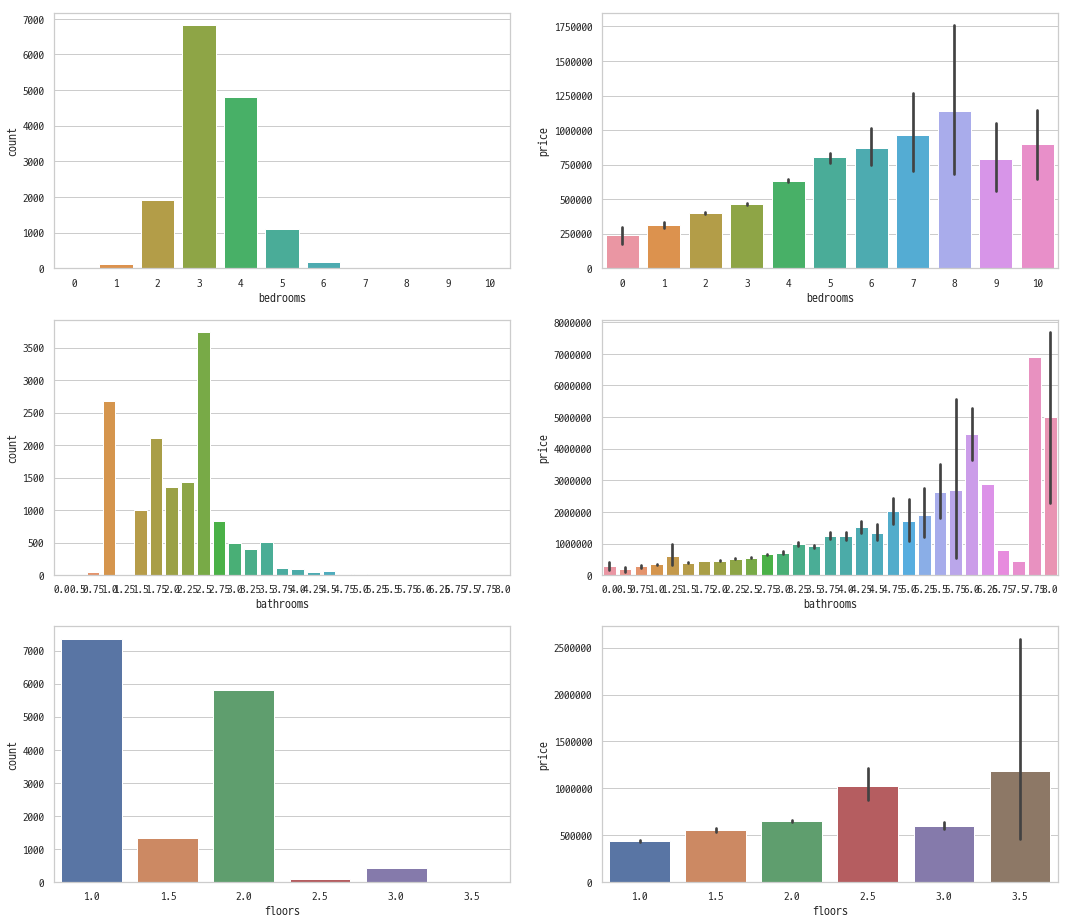

In [45]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(18, 16)

sns.countplot(data=data, x='bedrooms', ax=ax1)
sns.barplot(data=data, x='bedrooms', y='price', ax=ax2)
sns.countplot(data=data, x='bathrooms', ax=ax3)
sns.barplot(data=data, x='bathrooms', y='price', ax=ax4)
sns.countplot(data=data, x='floors', ax=ax5)
sns.barplot(data=data, x='floors', y='price', ax=ax6)
plt.show()

### `waterfront`, `view`, `condition`, `grade`

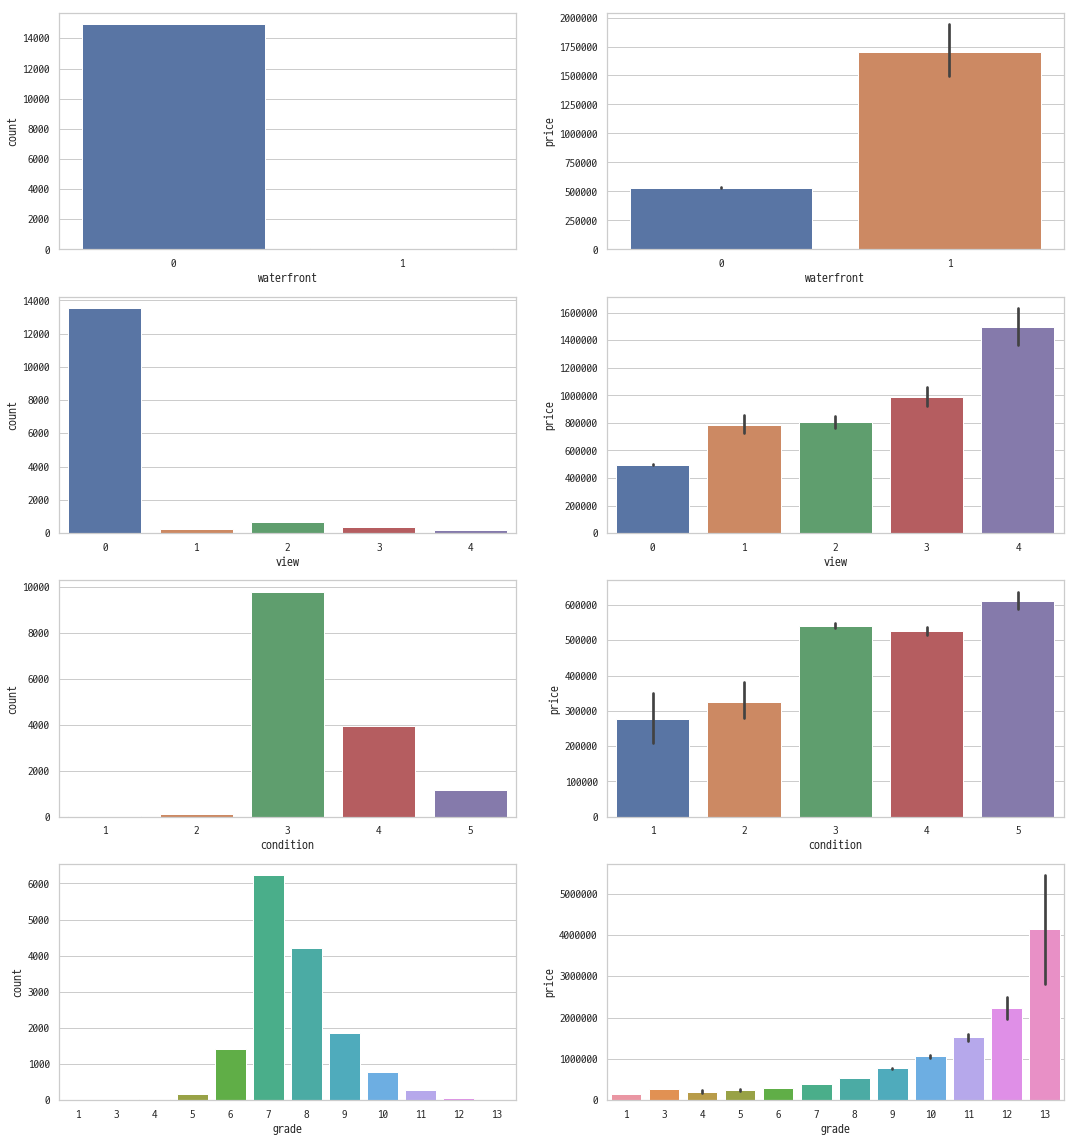

In [18]:
figure, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(nrows=4, ncols=2)
figure.set_size_inches(18, 20)

sns.countplot(data=data, x='waterfront', ax=ax1)
sns.barplot(data=data, x='waterfront', y='price', ax=ax2)
sns.countplot(data=data, x='view', ax=ax3)
sns.barplot(data=data, x='view', y='price', ax=ax4)
sns.countplot(data=data, x='condition', ax=ax5)
sns.barplot(data=data, x='condition', y='price', ax=ax6)
sns.countplot(data=data, x='grade', ax=ax7)
sns.barplot(data=data, x='grade', y='price', ax=ax8)
plt.show()

In [115]:
print("berooms outlier: ", len(data[data['bedrooms'] > 8]))
print("bathrooms outlier: ", len(data[data['bathrooms'] > 6]))
print("floors outlier: ", len(test[test['floors'] > 2.5]))

berooms outlier:  7
bathrooms outlier:  6
floors outlier:  198


- `bedrooms`, `bathrooms` 의 outliers 는 없애도 될 듯 하다

## Area features

In [16]:
areas = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
data[areas].describe()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
count,15035.000000,1.503500e+04,15035.000000,15035.000000,15035.000000,15035.000000
mean,2083.790223,1.529697e+04,1794.158164,289.632059,1992.754772,12823.884935
std,922.134087,4.261282e+04,831.738609,440.663284,691.456442,27736.259787
min,290.000000,5.200000e+02,290.000000,0.000000,399.000000,651.000000
25%,1430.000000,5.027500e+03,1190.000000,0.000000,1490.000000,5100.000000
50%,1910.000000,7.620000e+03,1570.000000,0.000000,1850.000000,7610.000000
75%,2560.000000,1.069550e+04,2230.000000,550.000000,2360.000000,10076.000000
max,13540.000000,1.651359e+06,9410.000000,4130.000000,6210.000000,871200.000000


- 총 6가지의 면적 컬럼이 존재한다.

### `sqft_basement`

In [17]:
data[areas].tail()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
id,,,,,,
15030,2520,6023,2520,0,2520,6023
15031,3510,7200,2600,910,2050,6200
15032,1530,1131,1530,0,1530,1509
15033,2310,5813,2310,0,1830,7200
15034,1020,1076,1020,0,1020,1357


- `sqft_basement` : 지하실이 없는 경우 0

In [18]:
len(data[data['sqft_basement'] == 0]) / len(data)

0.6081143997339541

- 약 60%의 데이터가 지하실이 없다
- 지하실이 있고 없고의 category를 만들어주면 좋을듯

### `sqft_basement_ohe`

- basement 값이 0이 아니면 1, 0이면 0으로 one-hot-encoding 해준다.

In [19]:
data['basement_ohe'] = data['sqft_basement'].apply(lambda x: 0 if x == 0 else 1)
data[['sqft_basement', 'basement_ohe']].tail()

,sqft_basement,basement_ohe
id,,
15030,0,0
15031,910,1
15032,0,0
15033,0,0
15034,0,0


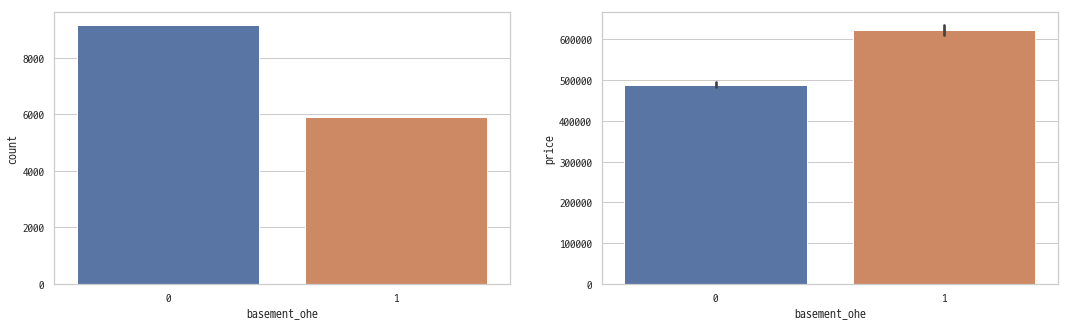

In [24]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 5)

sns.countplot(data['basement_ohe'], ax=ax1)
sns.barplot(x='basement_ohe', y='price', data=data, ax=ax2)
plt.show()

### \# Issue

In [20]:
data['living_is_true'] = data['sqft_above'] + data['sqft_basement'] == data['sqft_living']
data['living_is_true'].unique()

array([ True])

- `sqft_living` = `sqft_above` + `sqft_basement`
- 선형 종속인 이 세 컬럼은 어떻게 하는 게 좋을지..


- linear가 아니라면 다 갖고가도 상관 없을듯!

### `sqft_above`와 `sqft_basement`의 분포

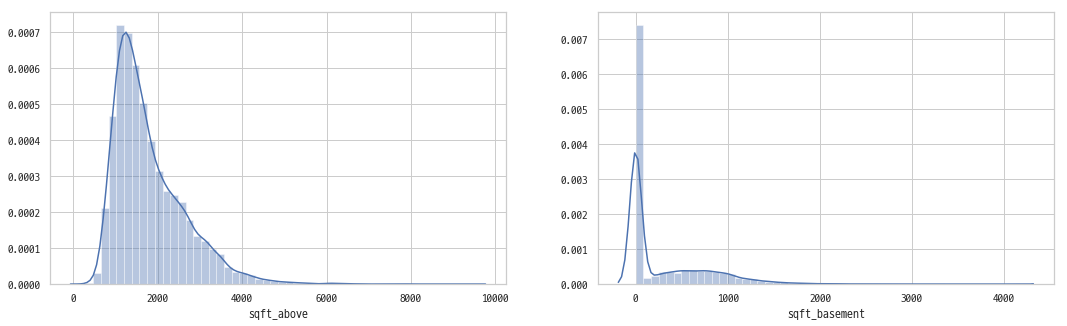

In [21]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 5)

sns.distplot(data['sqft_above'], ax=ax1)
sns.distplot(data['sqft_basement'], ax=ax2)
plt.show()

- 왜곡되어 있으므로 log변환으로 scaling을 해줄 수 있다. 

In [22]:
data['log_sqft_above'] = np.log(data['sqft_above'])
data.loc[data['sqft_basement'] > 0, 'log_sqft_basement'] = np.log(data['sqft_basement'])
data.loc[data['sqft_basement'] == 0, 'log_sqft_basement'] = 0

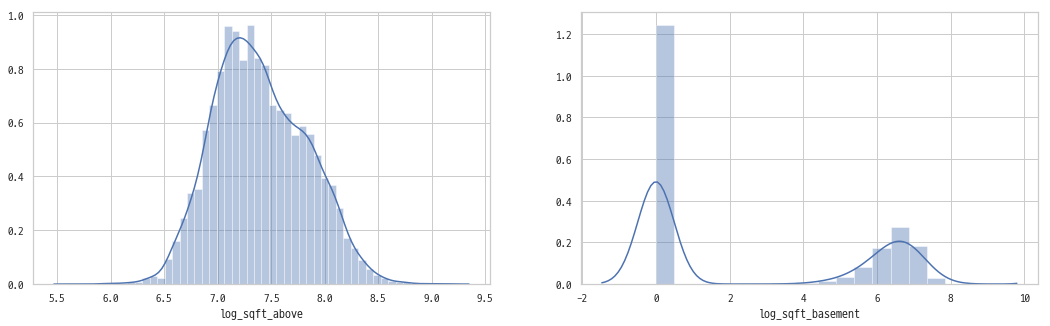

In [23]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 5)

sns.distplot(data['log_sqft_above'], ax=ax1)
sns.distplot(data['log_sqft_basement'], ax=ax2)
plt.show()

## `sqft_living`, `sqft_lot` : 15 or not?

In [18]:
area_corr = data[['sqft_living', 'sqft_lot', 'sqft_living15', 'sqft_lot15']].corr()
area_corr

,sqft_living,sqft_lot,sqft_living15,sqft_lot15
sqft_living,1.000000,0.176500,0.760271,0.184176
sqft_lot,0.176500,1.000000,0.147562,0.728458
sqft_living15,0.760271,0.147562,1.000000,0.183599
sqft_lot15,0.184176,0.728458,0.183599,1.000000


#### 상관관계 확인

- `sqft_living` & `sqft_living15` : 0.76

    
- `sqft_lot` & `sqft_lot15` : 0.72


> 꽤 높은 상관관계를 가진다.

### 면적이 넓어진 / 좁아진 집 확인

In [20]:
living_lot = ['log_price', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15']

In [21]:
data.loc[data['sqft_living'] < data['sqft_living15'], 'living_diff_cat'] = 'up'
data.loc[data['sqft_living'] > data['sqft_living15'], 'living_diff_cat'] = 'down'
data.loc[data['sqft_living'] == data['sqft_living15'], 'living_diff_cat'] = 'same'
data.loc[data['sqft_lot'] < data['sqft_lot15'], 'lot_diff_cat'] = 'up'
data.loc[data['sqft_lot'] > data['sqft_lot15'], 'lot_diff_cat'] = 'down'
data.loc[data['sqft_lot'] == data['sqft_lot15'], 'lot_diff_cat'] = 'same'

living_lot.insert(3, 'living_diff_cat')
living_lot.append('lot_diff_cat')
data[living_lot].head()

,log_price,sqft_living,sqft_living15,living_diff_cat,sqft_lot,sqft_lot15,lot_diff_cat
id,,,,,,,
0,12.309987,1180,1340,up,5650,5650,same
1,12.100718,770,2720,up,10000,8062,down
2,13.142168,1680,1800,up,8080,7503,down
3,12.458779,1715,2238,up,6819,6819,same
4,12.583999,1060,1650,up,9711,9711,same


In [27]:
data['living_diff_cat'].value_counts()

down    6858
up      6400
same    1777
Name: living_diff_cat, dtype: int64

In [28]:
data['lot_diff_cat'].value_counts()

down    6002
up      5918
same    3115
Name: lot_diff_cat, dtype: int64

- 면적이 넓어졌거나 좁아진 집은 비슷한 개수고, same으로 같은 집이 좀 더 적다.

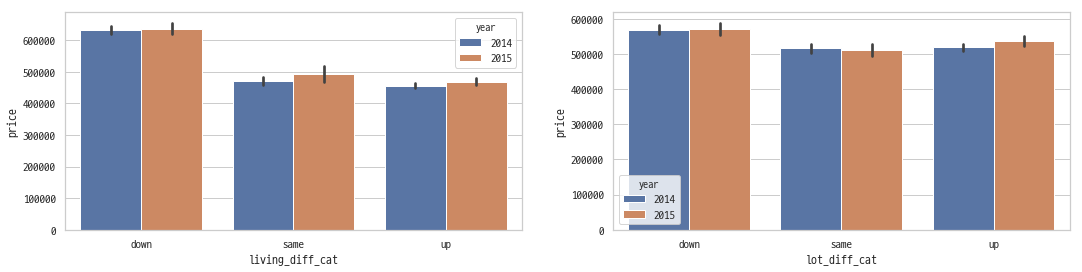

In [29]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.barplot(data=data, x="living_diff_cat", y="price", hue='year', order=['down', 'same', 'up'], ax=ax1)
sns.barplot(data=data, x="lot_diff_cat", y="price", hue='year', order=['down', 'same', 'up'], ax=ax2)
plt.show()

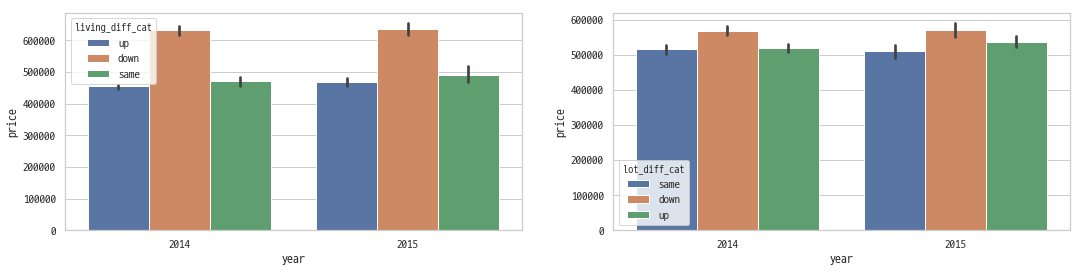

In [30]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.barplot(data=data, x="year", y="price", hue='living_diff_cat', ax=ax1)
sns.barplot(data=data, x="year", y="price", hue='lot_diff_cat', ax=ax2)
plt.show()

- 면적이 down된 집들이 주로 비싸다?

In [31]:
print(data[(data['living_diff_cat'] == 'down') & (data['lot_diff_cat'] == 'down')].shape)
data[(data['living_diff_cat'] == 'down') & (data['lot_diff_cat'] == 'down')][living_lot].describe().loc[['mean', 'min', 'max']]

(2992, 30)


,log_price,sqft_living,sqft_living15,sqft_lot,sqft_lot15
mean,13.232348,2685.970922,2094.337901,2.592127e+04,14632.043115
min,11.733987,870.000000,760.000000,1.036000e+03,651.000000
max,15.856731,13540.000000,5070.000000,1.074218e+06,858132.000000


> **큰집들**은 주로 재건축을 하면서 면적이 좁아졌음을 알 수 있다  
하지만 위에 플롯을 보면 가격은 크게 달라지지 않음

> 반대로 말하면, 좁았다가 넓어진 집들은 평균면적이 작다

### 차이값을 가지는 area column 생성

In [35]:
data['living_diff'] = data['sqft_living15'] - data['sqft_living']
data['lot_diff'] = data['sqft_lot15'] - data['sqft_lot']

living_lot.insert(4, 'living_diff')
living_lot.append('lot_diff')
data[living_lot].head()

,log_price,sqft_living,sqft_living15,living_diff_cat,living_diff,sqft_lot,sqft_lot15,lot_diff_cat,lot_diff
id,,,,,,,,,
0,12.309982,1180,1340,up,160,5650,5650,same,0
1,12.100712,770,2720,up,1950,10000,8062,down,-1938
2,13.142166,1680,1800,up,120,8080,7503,down,-577
3,12.458775,1715,2238,up,523,6819,6819,same,0
4,12.583995,1060,1650,up,590,9711,9711,same,0


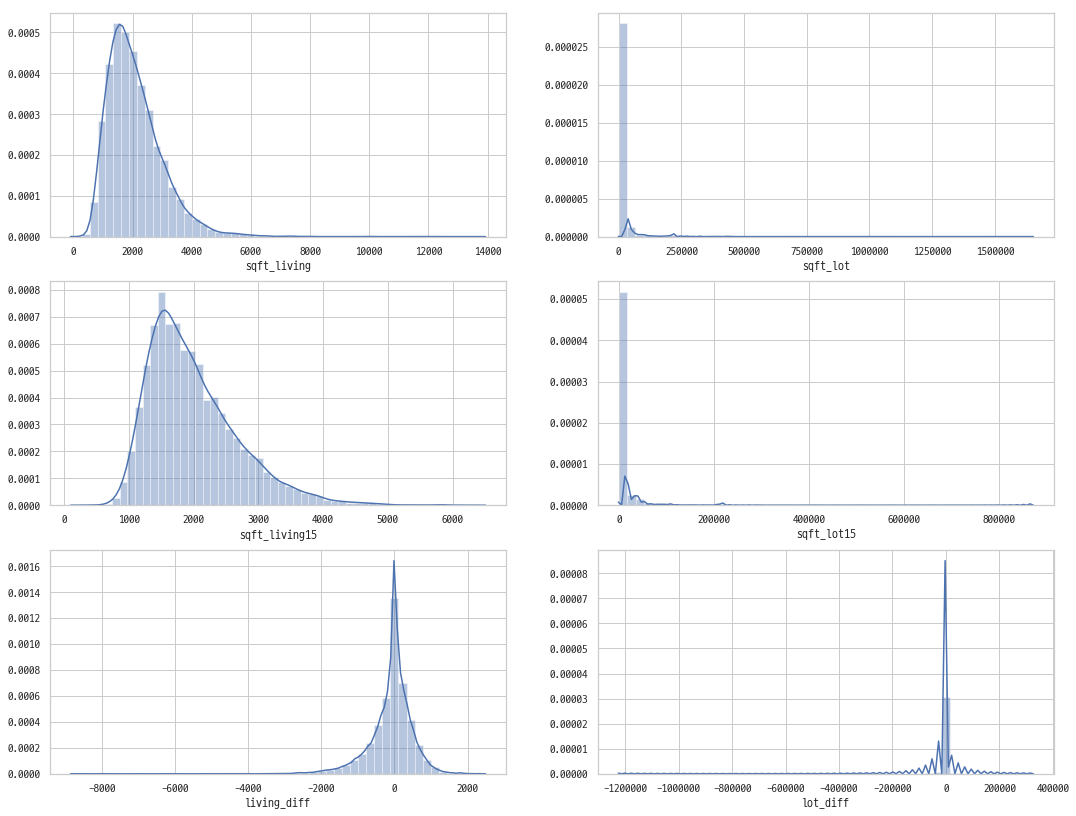

In [36]:
figure, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(18, 14)

sns.distplot(data['sqft_living'], ax=ax1)
sns.distplot(data['sqft_living15'], ax=ax2)
sns.distplot(data['living_diff'], ax=ax3)
sns.distplot(data['sqft_lot'], ax=ax4)
sns.distplot(data['sqft_lot15'], ax=ax5)
sns.distplot(data['lot_diff'], ax=ax6)
plt.show()

#### Outlier 제거

In [38]:
lot_outliers = data[(data['lot_diff'] < -200000) | (data['lot_diff'] > 200000)].index
print("lot outliers 개수: ", len(lot_outliers))
data.drop(lot_outliers, inplace=True)
data.shape

lot outliers 개수:  55


(14980, 32)

In [39]:
living_outliers = data[(data['living_diff'] < -4000) | (data['living_diff'] > 2000)].index
print("living outliers 개수: ", len(living_outliers))
data.drop(living_outliers, inplace=True)
data.shape

living outliers 개수:  21


(14959, 32)

#### 제거 후 plot 다시 확인

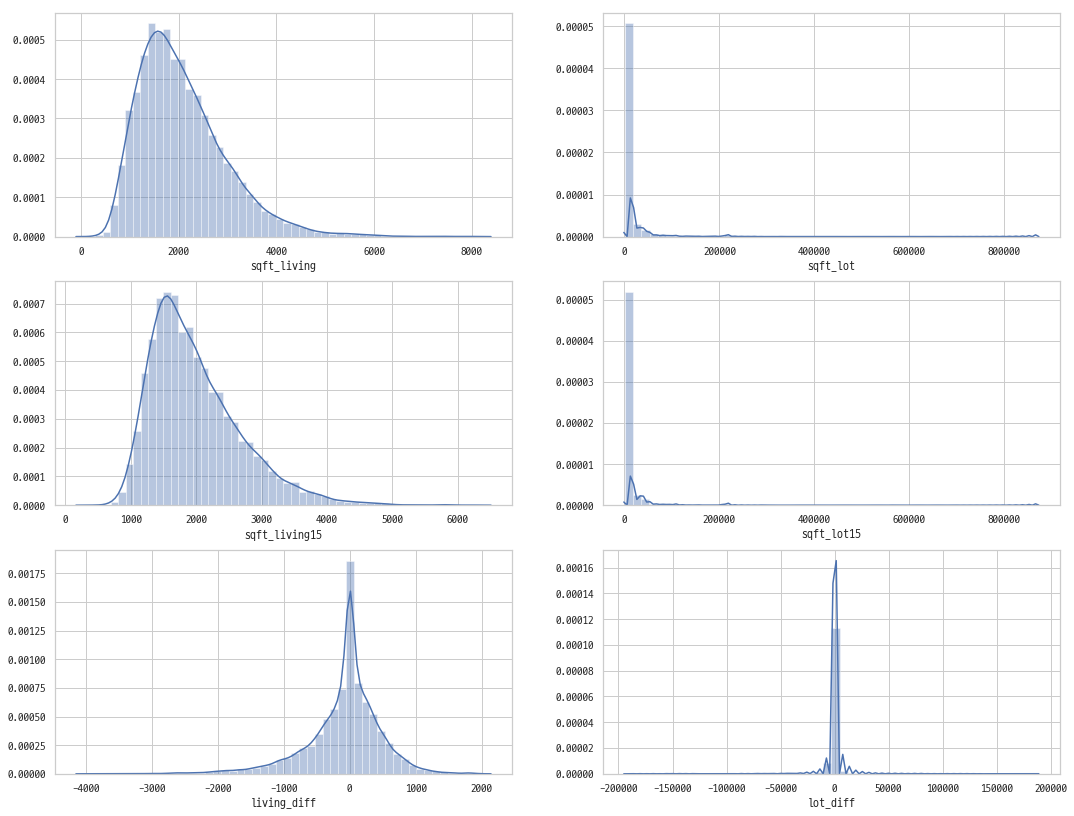

In [40]:
figure, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(18, 14)

sns.distplot(data['sqft_living'], ax=ax1)
sns.distplot(data['sqft_living15'], ax=ax2)
sns.distplot(data['living_diff'], ax=ax3)
sns.distplot(data['sqft_lot'], ax=ax4)
sns.distplot(data['sqft_lot15'], ax=ax5)
sns.distplot(data['lot_diff'], ax=ax6)
plt.show()

### Log 변환

In [41]:
data['log_sqft_living'] = np.log(data['sqft_living'])
data['log_sqft_living15'] = np.log(data['sqft_living15'])
data.loc[data['living_diff'] > 0, 'log_living_diff'] = np.log(data['living_diff'])
data.loc[data['living_diff'] < 0, 'log_living_diff'] = -np.log(-data['living_diff'])
data.loc[data['living_diff'] == 0, 'log_living_diff'] = 0
data['log_sqft_lot'] = np.log(data['sqft_lot'])
data['log_sqft_lot15'] = np.log(data['sqft_lot15'])
data.loc[data['lot_diff'] > 0, 'log_lot_diff'] = np.log(data['lot_diff'])
data.loc[data['lot_diff'] < 0, 'log_lot_diff'] = -np.log(-data['lot_diff'])
data.loc[data['lot_diff'] == 0, 'log_lot_diff'] = 0

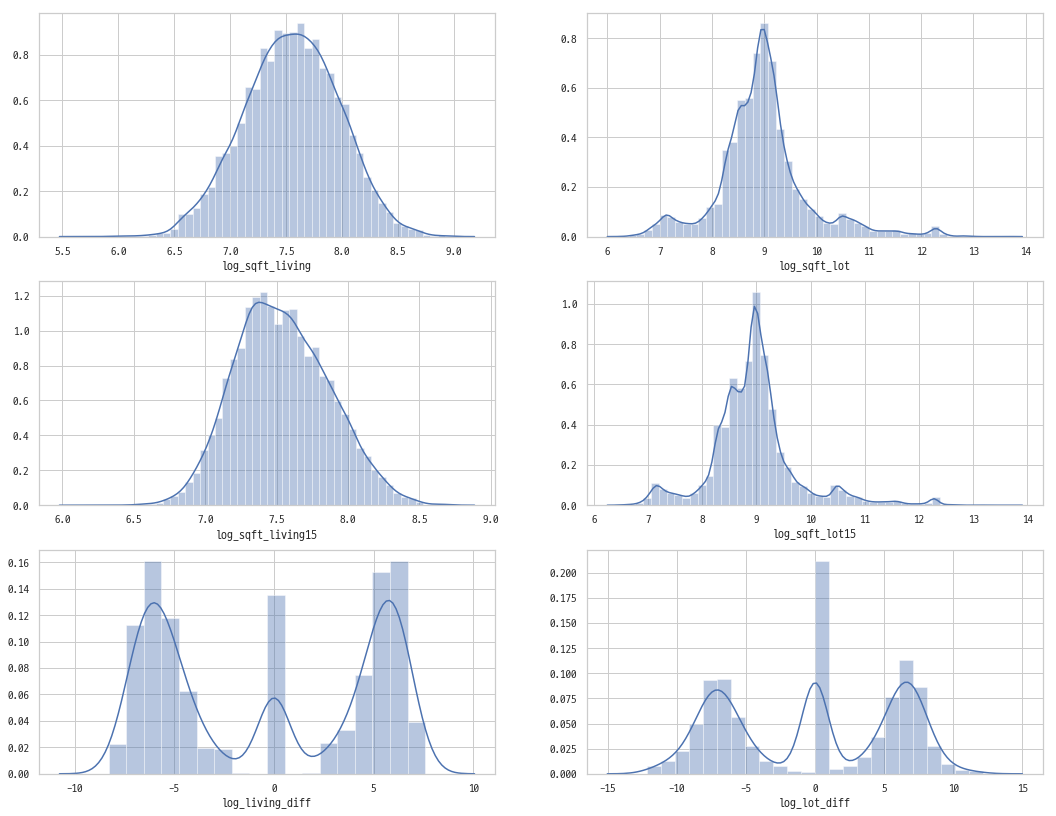

In [42]:
figure, ((ax1, ax4), (ax2, ax5), (ax3, ax6)) = plt.subplots(nrows=3, ncols=2)
figure.set_size_inches(18, 14)

sns.distplot(data['log_sqft_living'], ax=ax1)
sns.distplot(data['log_sqft_living15'], ax=ax2)
sns.distplot(data['log_living_diff'], ax=ax3)
sns.distplot(data['log_sqft_lot'], ax=ax4)
sns.distplot(data['log_sqft_lot15'], ax=ax5)
sns.distplot(data['log_lot_diff'], ax=ax6)
plt.show()

## `waterfront`

In [43]:
data['waterfront'].value_counts()

0    14855
1      104
Name: waterfront, dtype: int64

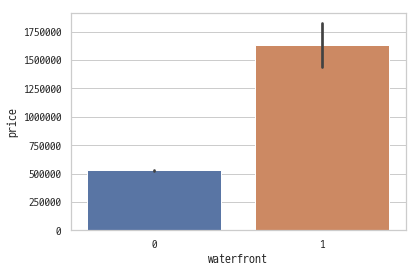

In [44]:
sns.barplot(data=data, x="waterfront", y="price")
plt.show()

- `waterfront == 1`, 즉 강이 보이는 집은 확실히 비싸다

## `view`

In [45]:
data['view'].value_counts()

0    13499
2      654
3      364
1      240
4      202
Name: view, dtype: int64

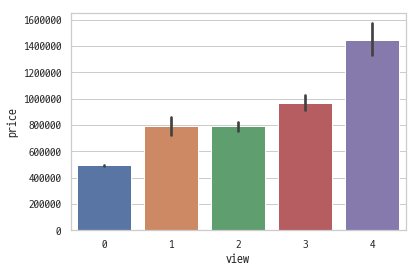

In [46]:
sns.barplot(data=data, x="view", y="price")
plt.show()

- view가 좋을수록 비싼 것도 확인

## `condition`

In [47]:
data['condition'].value_counts()

3    9747
4    3935
5    1149
2     108
1      20
Name: condition, dtype: int64

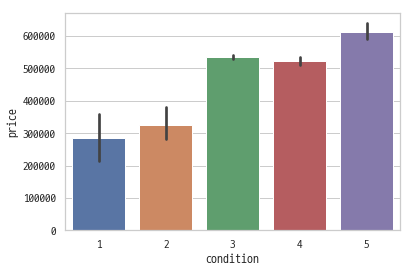

In [48]:
sns.barplot(data=data, x="condition", y="price")
plt.show()

- condition도 상관관계 있고

## `grade`

In [49]:
data['grade'].value_counts()

7     6212
8     4199
9     1844
6     1399
10     773
11     276
5      172
12      55
4       22
13       4
3        2
1        1
Name: grade, dtype: int64

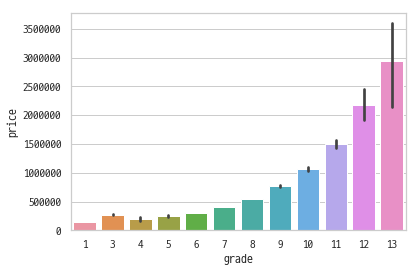

In [50]:
sns.barplot(data=data, x="grade", y="price")
plt.show()

- grade는 아주 있고

## `yr_built`

In [56]:
built_year = np.array(sorted(data['yr_built'].unique()))
built_year

array([1900, 1901, 1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910,
       1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921,
       1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015])

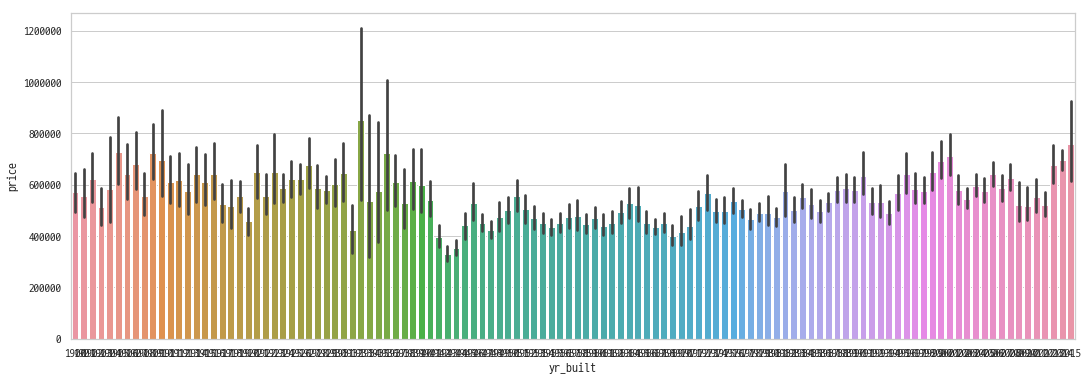

In [57]:
plt.figure(figsize=(18, 6))
sns.barplot(data=data, x="yr_built", y="price", order=built_year)
plt.show()

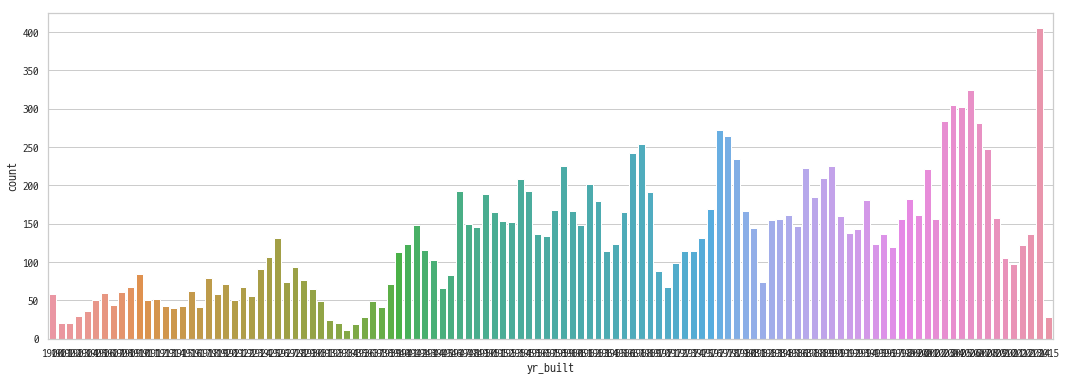

In [55]:
plt.figure(figsize=(18, 6))
sns.countplot(data=data, x="yr_built")
plt.show()

- 눈으로 봐서는 큰 경향성은 알 수 없다

## `yr_renovated`

In [53]:
print(len(data[data['yr_renovated'] == 0]))
print(len(data[data['yr_renovated'] != 0]))

14333
626


In [54]:
626 / (14333+626)

0.041847717093388595

- 재건축이 된 집은 전체의 4%밖에 안되므로 category data로 활용할 수 있을 것이라 생각

#### `renovated_ohe` 생성

In [55]:
data['renovated_ohe'] = data['yr_renovated'].apply(lambda i: 0 if i == 0 else 1)

In [56]:
data['renovated_ohe'].value_counts()

0    14333
1      626
Name: renovated_ohe, dtype: int64

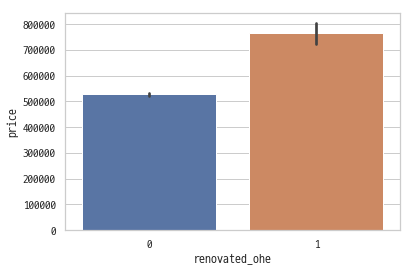

In [57]:
sns.barplot(data=data, x="renovated_ohe", y="price")
plt.show()

## `zipcode`

In [24]:
data['zipcode'].min(), data['zipcode'].max()

(98001, 98199)

- zipcode는 `98001` ~ `98199` 사이로 이루어져있다. : 워싱턴주의 특정 구역

- 워싱턴주의 최고 집값을 가진 zipcodes : [washington state house price](https://www.propertyshark.com/Real-Estate-Reports/2017/10/04/expensive-zip-codes-washington-state-medina-homes-8x-pricier-u-s-median/)

![](zipcode.png)

#### 1등 동네 실제 확인

In [25]:
data['log_price'].describe().loc[["75%", "max"]]

75%    13.377007
max    15.856731
Name: log_price, dtype: float64

- 75% 분위의 log_price 값이 13.3 이상인데

In [26]:
print("Mean: ", data[data['zipcode'] == 98039]['log_price'].mean())
data[data['zipcode'] == 98039]['log_price'][:10]

Mean:  14.50783350861788


id
2123    14.897316
3134    15.532906
3678    13.963931
5790    14.093143
6469    15.744856
6762    13.670486
6850    13.815512
7859    14.557448
8579    14.353611
8933    13.576620
Name: log_price, dtype: float64

> 실제로 죄다 그 이상이고, 평균은 14.43 !

### zipcode ranking DataFrame 생성

In [43]:
zipcode_outdata = pd.read_csv("./zipcode.csv", index_col='zipcode')
zipcode_outdata['rank'] = np.arange(1, 51)
print(zipcode_outdata.shape)
zipcode_outdata.head()

(50, 2)


,city,rank
zipcode,,
98039,Medina,1
98004,Bellevue,2
98040,Mercer,3
98112,Seattle,4
98075,Sammamish,5


- 이건 위의 링크에서 설명하는 워싱턴주의 비싼 도시 순위

In [44]:
zipcode_rank = data.groupby(['zipcode']).mean().sort_values(by=['price'], \
                                                              ascending=False).reset_index()[['zipcode', 'price']]
zipcode_rank['rank'] = range(1, len(zipcode_rank)+1)
zipcode_rank.head()

,zipcode,price,rank
0,98039,2.245862e+06,1
1,98004,1.397283e+06,2
2,98040,1.204216e+06,3
3,98112,1.118553e+06,4
4,98102,9.043680e+05,5


### 1~50위를 순위를 매기고, 그 외는 0으로 설정하기

In [39]:
def get_ziprank(data):
    zipcode_rank = data.groupby(['zipcode']).mean().sort_values(by=['price'], \
                                                                ascending=False).reset_index()[['zipcode', 'price']]
    zipcode_rank['rank'] = range(1, len(zipcode_rank)+1)
    zipcode_rank_dict = zipcode_rank.set_index(['zipcode'])['rank'].to_dict()
    
    return zipcode_rank_dict

In [42]:
zipcode_rank_dict = get_ziprank(data)
pd.DataFrame(zipcode_rank_dict, index=['rank']).T.head(10)

,rank
98039,1
98004,2
98040,3
98112,4
98102,5
98109,6
98105,7
98119,8
98006,9
98199,10


In [36]:
data['zipcode_rank'] = data['zipcode'].apply(lambda i: zipcode_rank_dict[i])
zipcode_rank.head()

,zipcode,price,rank
0,98039,2.245862e+06,1
1,98004,1.397283e+06,2
2,98040,1.204216e+06,3
3,98112,1.118553e+06,4
4,98102,9.043680e+05,5


- ranking 별로 잘 만들어짐!

In [37]:
data['zipcode_all_rank'] = data['zipcode'].apply(lambda i: zipcode_rank_dict[i])
data[['zipcode', 'zipcode_all_rank']].head()

,zipcode,zipcode_all_rank
id,,
0,98178,58
1,98028,40
2,98074,14
3,98003,64
4,98198,60


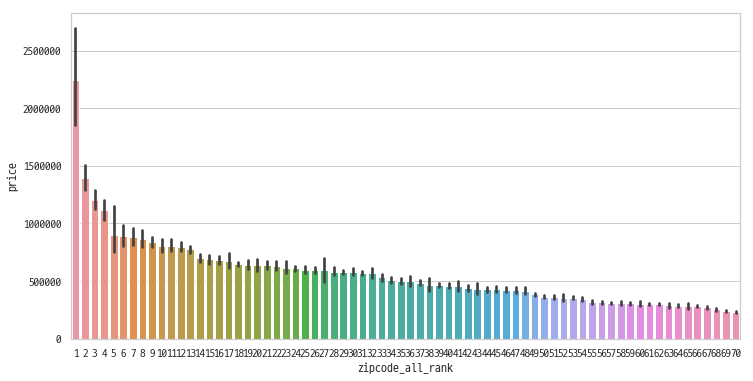

In [47]:
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x="zipcode_all_rank", y="price")
plt.show()

## `lat`, `long`

In [49]:
data[['lat', 'long']].describe()

,lat,long
count,15035.000000,15035.000000
mean,47.560721,-122.213677
std,0.138164,0.141294
min,47.155900,-122.519000
25%,47.472700,-122.328000
50%,47.571900,-122.231000
75%,47.678300,-122.126000
max,47.777600,-121.315000


- 편차가 너무 작아서 분리되기 어려울 수 있으므로 표준화를 통해 편차를 1로 만들어준다

In [50]:
data['lat_scale'] = (data['lat'] - data['lat'].mean()) / data['lat'].std()
data['long_scale'] = (data['long'] - data['long'].mean()) / data['long'].std()
data[['lat', 'lat_scale', 'long', 'long_scale']].head()

,lat,lat_scale,long,long_scale
id,,,,
0,47.5112,-0.358419,-122.257,-0.306616
1,47.7379,1.282383,-122.233,-0.136758
2,47.6168,0.405889,-122.045,1.193796
3,47.3097,-1.816828,-122.327,-0.802035
4,47.4095,-1.094499,-122.315,-0.717106


In [51]:
data[['lat_scale', 'long_scale']].describe()

,lat_scale,long_scale
count,1.503500e+04,1.503500e+04
mean,2.025886e-15,5.225407e-14
std,1.000000e+00,1.000000e+00
min,-2.929996e+00,-2.160900e+00
25%,-6.370725e-01,-8.091128e-01
50%,8.091373e-02,-1.226034e-01
75%,8.510118e-01,6.205254e-01
max,1.569722e+00,6.360311e+00


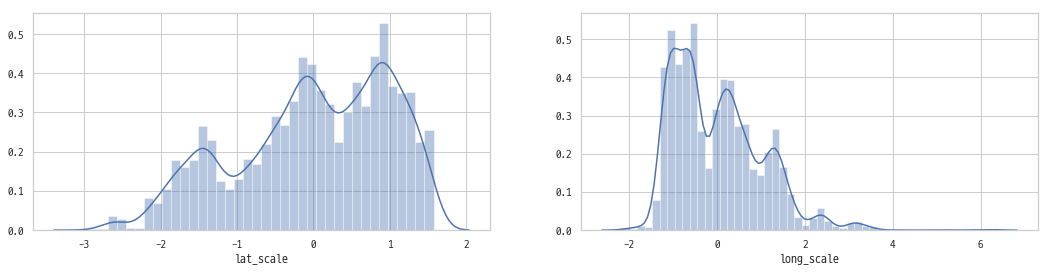

In [52]:
figure, ((ax1, ax2)) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(18, 4)

sns.distplot(data['lat_scale'], ax=ax1)
sns.distplot(data['long_scale'], ax=ax2)
plt.show()

### 03/24 Issue
- 위도와 경도는 엄연히 `bounded` (막혀있는) 값이므로 무한대의 분포를 가정하는 정규분포로 scaling하면 안됨.
- 위도와 경도에 알맞은 whitening이 있으니 더 알아보고 scaling을 해야 함.

### Outlier

In [53]:
len(data[data['long_scale'] > 4])

15

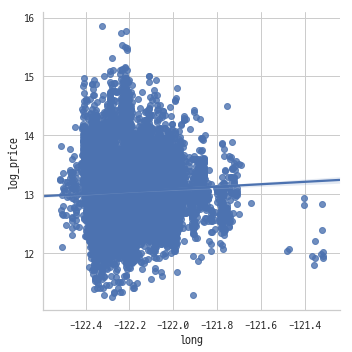

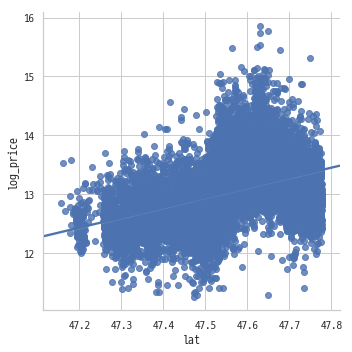

In [54]:
sns.lmplot(data=data, x='long', y='log_price')
sns.lmplot(data=data, x='lat', y='log_price')
plt.show()

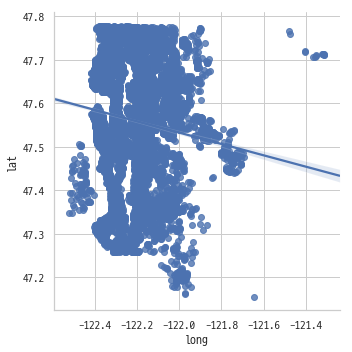

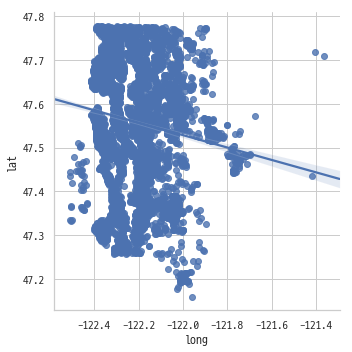

In [55]:
sns.lmplot(data=data, x='long', y='lat')
sns.lmplot(data=test, x='long', y='lat')
plt.show()

- Outlier 삭제

In [77]:
print(data.shape)
long_outlier = data[data['long_scale'] > 4].index
print(len(long_outlier))
data = data.drop(long_outlier)
print(data.shape)

(14959, 43)
15
(14944, 43)


---

### 지금까지 만들어진 column 확인

In [56]:
print(len(data.columns))
data.columns

32


Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'log_price', 'year', 'month', 'day',
       'year_month', 'day_of_week', 'living_diff_cat', 'lot_diff_cat',
       'zipcode_rank', 'zipcode_all_rank', 'lat_scale', 'long_scale'],
      dtype='object')